In [2]:
import pandas as pd
import sklearn
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.metrics import mean_squared_error
import numpy as np
import pickle

In [3]:
pd.__version__

'2.3.0'

In [1]:
import mlflow
mlflow.set_tracking_uri('sqlite:///mlflow.db')
mlflow.set_experiment('nyc-taxi-experiment') ##check if the experiment exists.. and assigns all the experimnets to it


2025/07/02 11:23:14 INFO mlflow.store.db.utils: Creating initial MLflow database tables...
2025/07/02 11:23:14 INFO mlflow.store.db.utils: Updating database tables
INFO  [alembic.runtime.migration] Context impl SQLiteImpl.
INFO  [alembic.runtime.migration] Will assume non-transactional DDL.
INFO  [alembic.runtime.migration] Context impl SQLiteImpl.
INFO  [alembic.runtime.migration] Will assume non-transactional DDL.
2025/07/02 11:23:14 INFO mlflow.tracking.fluent: Experiment with name 'nyc-taxi-experiment' does not exist. Creating a new experiment.


<Experiment: artifact_location='/workspaces/mlops/02-experiment-tracking/mlruns/1', creation_time=1751455394278, experiment_id='1', last_update_time=1751455394278, lifecycle_stage='active', name='nyc-taxi-experiment', tags={}>

In [4]:
df = pd.read_parquet('../data/green_tripdata_2021-01.parquet')

In [5]:
df.head()

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,extra,mta_tax,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge
0,2,2021-01-01 00:15:56,2021-01-01 00:19:52,N,1.0,43,151,1.0,1.01,5.5,0.5,0.5,0.00,0.0,None,0.3,6.80,2.0,1.0,0.00
1,2,2021-01-01 00:25:59,2021-01-01 00:34:44,N,1.0,166,239,1.0,2.53,10.0,0.5,0.5,2.81,0.0,None,0.3,16.86,1.0,1.0,2.75
2,2,2021-01-01 00:45:57,2021-01-01 00:51:55,N,1.0,41,42,1.0,1.12,6.0,0.5,0.5,1.00,0.0,None,0.3,8.30,1.0,1.0,0.00
3,2,2020-12-31 23:57:51,2021-01-01 00:04:56,N,1.0,168,75,1.0,1.99,8.0,0.5,0.5,0.00,0.0,None,0.3,9.30,2.0,1.0,0.00
4,2,2021-01-01 00:16:36,2021-01-01 00:16:40,N,2.0,265,265,3.0,0.00,-52.0,0.0,-0.5,0.00,0.0,None,-0.3,-52.80,3.0,1.0,0.00


In [6]:
df.shape

(76518, 20)

In [7]:
df['lpep_pickup_datetime'] = pd.to_datetime(df['lpep_pickup_datetime'])
df['lpep_dropoff_datetime'] = pd.to_datetime(df['lpep_dropoff_datetime'])

In [8]:
df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime

In [9]:
df

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,...,mta_tax,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge,duration
0,2,2021-01-01 00:15:56,2021-01-01 00:19:52,N,1.0,43,151,1.0,1.01,5.50,...,0.5,0.00,0.00,None,0.3,6.80,2.0,1.0,0.00,0 days 00:03:56
1,2,2021-01-01 00:25:59,2021-01-01 00:34:44,N,1.0,166,239,1.0,2.53,10.00,...,0.5,2.81,0.00,None,0.3,16.86,1.0,1.0,2.75,0 days 00:08:45
2,2,2021-01-01 00:45:57,2021-01-01 00:51:55,N,1.0,41,42,1.0,1.12,6.00,...,0.5,1.00,0.00,None,0.3,8.30,1.0,1.0,0.00,0 days 00:05:58
3,2,2020-12-31 23:57:51,2021-01-01 00:04:56,N,1.0,168,75,1.0,1.99,8.00,...,0.5,0.00,0.00,None,0.3,9.30,2.0,1.0,0.00,0 days 00:07:05
4,2,2021-01-01 00:16:36,2021-01-01 00:16:40,N,2.0,265,265,3.0,0.00,-52.00,...,-0.5,0.00,0.00,None,-0.3,-52.80,3.0,1.0,0.00,0 days 00:00:04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76513,2,2021-01-31 21:38:00,2021-01-31 22:16:00,None,NaN,81,90,NaN,17.63,56.23,...,0.0,0.00,6.12,None,0.3,65.40,NaN,NaN,NaN,0 days 00:38:00
76514,2,2021-01-31 22:43:00,2021-01-31 23:21:00,None,NaN,35,213,NaN,18.36,46.66,...,0.0,12.20,6.12,None,0.3,65.28,NaN,NaN,NaN,0 days 00:38:00
76515,2,2021-01-31 22:16:00,2021-01-31 22:27:00,None,NaN,74,69,NaN,2.50,18.95,...,0.0,0.00,0.00,None,0.3,22.00,NaN,NaN,NaN,0 days 00:11:00
76516,2,2021-01-31 23:10:00,2021-01-31 23:37:00,None,NaN,168,215,NaN,14.48,48.87,...,0.0,0.00,6.12,None,0.3,58.04,NaN,NaN,NaN,0 days 00:27:00


In [10]:
df.duration

0       0 days 00:03:56
1       0 days 00:08:45
2       0 days 00:05:58
3       0 days 00:07:05
4       0 days 00:00:04
              ...      
76513   0 days 00:38:00
76514   0 days 00:38:00
76515   0 days 00:11:00
76516   0 days 00:27:00
76517   0 days 00:10:00
Name: duration, Length: 76518, dtype: timedelta64[us]

In [11]:
td = df.duration.iloc[0]

In [12]:
td

Timedelta('0 days 00:03:56')

In [13]:
td.total_seconds() / 60

3.933333333333333

In [14]:
df.duration = df.duration.apply(lambda td : td.total_seconds() / 60)

In [15]:
df.duration

0         3.933333
1         8.750000
2         5.966667
3         7.083333
4         0.066667
           ...    
76513    38.000000
76514    38.000000
76515    11.000000
76516    27.000000
76517    10.000000
Name: duration, Length: 76518, dtype: float64

In [16]:
df.shape

(76518, 21)

In [17]:
df.duration.describe()

count    76518.000000
mean        19.927896
std         59.338594
min          0.000000
25%          8.000000
50%         13.883333
75%         23.000000
max       1439.600000
Name: duration, dtype: float64

In [18]:
df.duration.describe(percentiles=[0.95, 0.98, 0.99])

count    76518.000000
mean        19.927896
std         59.338594
min          0.000000
50%         13.883333
95%         44.000000
98%         56.000000
99%         67.158167
max       1439.600000
Name: duration, dtype: float64

In [19]:
((df.duration >= 1) & (df.duration <= 60)).mean()

np.float64(0.9658903787344154)

In [20]:
df = df[(df.duration >= 1) & (df.duration <= 60)]

In [21]:
df

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,...,mta_tax,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge,duration
0,2,2021-01-01 00:15:56,2021-01-01 00:19:52,N,1.0,43,151,1.0,1.01,5.50,...,0.5,0.00,0.00,None,0.3,6.80,2.0,1.0,0.00,3.933333
1,2,2021-01-01 00:25:59,2021-01-01 00:34:44,N,1.0,166,239,1.0,2.53,10.00,...,0.5,2.81,0.00,None,0.3,16.86,1.0,1.0,2.75,8.750000
2,2,2021-01-01 00:45:57,2021-01-01 00:51:55,N,1.0,41,42,1.0,1.12,6.00,...,0.5,1.00,0.00,None,0.3,8.30,1.0,1.0,0.00,5.966667
3,2,2020-12-31 23:57:51,2021-01-01 00:04:56,N,1.0,168,75,1.0,1.99,8.00,...,0.5,0.00,0.00,None,0.3,9.30,2.0,1.0,0.00,7.083333
7,2,2021-01-01 00:26:31,2021-01-01 00:28:50,N,1.0,75,75,6.0,0.45,3.50,...,0.5,0.96,0.00,None,0.3,5.76,1.0,1.0,0.00,2.316667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76513,2,2021-01-31 21:38:00,2021-01-31 22:16:00,None,NaN,81,90,NaN,17.63,56.23,...,0.0,0.00,6.12,None,0.3,65.40,NaN,NaN,NaN,38.000000
76514,2,2021-01-31 22:43:00,2021-01-31 23:21:00,None,NaN,35,213,NaN,18.36,46.66,...,0.0,12.20,6.12,None,0.3,65.28,NaN,NaN,NaN,38.000000
76515,2,2021-01-31 22:16:00,2021-01-31 22:27:00,None,NaN,74,69,NaN,2.50,18.95,...,0.0,0.00,0.00,None,0.3,22.00,NaN,NaN,NaN,11.000000
76516,2,2021-01-31 23:10:00,2021-01-31 23:37:00,None,NaN,168,215,NaN,14.48,48.87,...,0.0,0.00,6.12,None,0.3,58.04,NaN,NaN,NaN,27.000000


In [22]:
categorical = ['PULocationID', 'DOLocationID']
numerical = ['trip_distance']

In [23]:
df[categorical].dtypes

PULocationID    int64
DOLocationID    int64
dtype: object

In [24]:
df[categorical] = df[categorical].astype(str)
df[categorical].dtypes

/tmp/ipykernel_10183/1926353661.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[categorical] = df[categorical].astype(str)


PULocationID    object
DOLocationID    object
dtype: object

In [25]:
df[categorical + numerical][:10].to_dict(orient = 'records')

[{'PULocationID': '43', 'DOLocationID': '151', 'trip_distance': 1.01},
 {'PULocationID': '166', 'DOLocationID': '239', 'trip_distance': 2.53},
 {'PULocationID': '41', 'DOLocationID': '42', 'trip_distance': 1.12},
 {'PULocationID': '168', 'DOLocationID': '75', 'trip_distance': 1.99},
 {'PULocationID': '75', 'DOLocationID': '75', 'trip_distance': 0.45},
 {'PULocationID': '225', 'DOLocationID': '265', 'trip_distance': 12.19},
 {'PULocationID': '244', 'DOLocationID': '244', 'trip_distance': 3.39},
 {'PULocationID': '75', 'DOLocationID': '213', 'trip_distance': 6.69},
 {'PULocationID': '74', 'DOLocationID': '238', 'trip_distance': 2.34},
 {'PULocationID': '74', 'DOLocationID': '60', 'trip_distance': 5.48}]

In [26]:
train_dicts = df[categorical + numerical].to_dict(orient = 'records')

In [27]:
dv = DictVectorizer()
X_train = dv.fit_transform(train_dicts)

In [28]:
dv.feature_names_

['DOLocationID=1',
 'DOLocationID=10',
 'DOLocationID=100',
 'DOLocationID=101',
 'DOLocationID=102',
 'DOLocationID=106',
 'DOLocationID=107',
 'DOLocationID=108',
 'DOLocationID=109',
 'DOLocationID=11',
 'DOLocationID=111',
 'DOLocationID=112',
 'DOLocationID=113',
 'DOLocationID=114',
 'DOLocationID=115',
 'DOLocationID=116',
 'DOLocationID=117',
 'DOLocationID=118',
 'DOLocationID=119',
 'DOLocationID=12',
 'DOLocationID=120',
 'DOLocationID=121',
 'DOLocationID=122',
 'DOLocationID=123',
 'DOLocationID=124',
 'DOLocationID=125',
 'DOLocationID=126',
 'DOLocationID=127',
 'DOLocationID=128',
 'DOLocationID=129',
 'DOLocationID=13',
 'DOLocationID=130',
 'DOLocationID=131',
 'DOLocationID=132',
 'DOLocationID=133',
 'DOLocationID=134',
 'DOLocationID=135',
 'DOLocationID=136',
 'DOLocationID=137',
 'DOLocationID=138',
 'DOLocationID=139',
 'DOLocationID=14',
 'DOLocationID=140',
 'DOLocationID=141',
 'DOLocationID=142',
 'DOLocationID=143',
 'DOLocationID=144',
 'DOLocationID=145',

In [29]:
y_train = df.duration

In [30]:
lr = LinearRegression()

In [31]:
lr.fit(X_train, y_train)

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


In [32]:
y_pred = lr.predict(X_train)

/tmp/ipykernel_10183/3891263932.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_pred, label = 'prediction')
/tmp/ipykernel_10183/3891263932.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_train, label = 'actual')


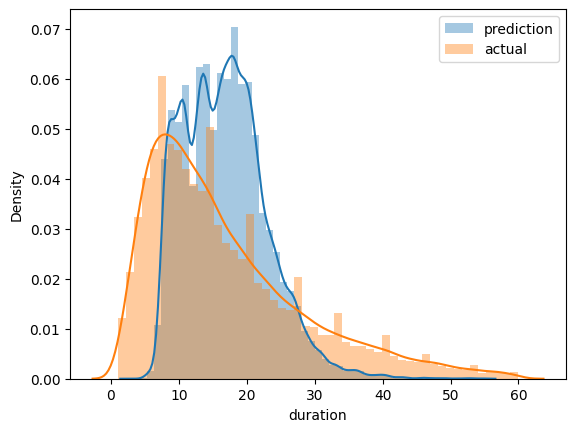

In [33]:
sns.distplot(y_pred, label = 'prediction')
sns.distplot(y_train, label = 'actual')
plt.legend()

In [34]:
rmse = np.sqrt(mean_squared_error(y_train, y_pred))
print("RMSE:", rmse)

RMSE: 9.838799799829621


# Code Restructuring

In [35]:
def read_dataframe(filename):
    df = pd.read_parquet(filename)
    df['lpep_pickup_datetime'] = pd.to_datetime(df['lpep_pickup_datetime'])
    df['lpep_dropoff_datetime'] = pd.to_datetime(df['lpep_dropoff_datetime'])
    
    df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
    
    df.duration = df.duration.apply(lambda td : td.total_seconds() / 60)
    
    df = df[(df.duration >= 1) & (df.duration <= 60)]
    
    categorical = ['PULocationID', 'DOLocationID']
    
    df[categorical] = df[categorical].astype(str)

    return df

In [36]:
df_train = read_dataframe('../data/green_tripdata_2021-01.parquet')
df_val = read_dataframe('../data/green_tripdata_2021-02.parquet')

In [37]:
len(df_train), len(df_val)

(73908, 61921)

In [38]:
df_train['PU_DO'] = df_train['PULocationID'] + '_' + df_train['DOLocationID']
df_val['PU_DO'] = df_val['PULocationID'] + '_' + df_val['DOLocationID']

In [39]:
# categorical = ['PULocationID', 'DOLocationID']
categorical = ['PU_DO']
numerical = ['trip_distance']

dv = DictVectorizer()

train_dicts = df_train[categorical + numerical].to_dict(orient = 'records')
X_train = dv.fit_transform(train_dicts)

valid_dicts = df_val[categorical + numerical].to_dict(orient = 'records')
X_val = dv.transform(valid_dicts)

In [40]:
y_train = df_train.duration
y_val = df_val.duration

In [41]:
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)
np.sqrt(mean_squared_error(y_pred, y_val))

np.float64(7.758715206809494)

In [42]:
with open('models/lin_reg.bin', 'wb') as f_out:
    pickle.dump((dv, lr), f_out) ## saving dict vectorizer and model, ## save theses two in fout

# CLeaned Version

In [43]:
# df = pd.read_parquet(filename)
# df['lpep_pickup_datetime'] = pd.to_datetime(df['lpep_pickup_datetime'])
# df['lpep_dropoff_datetime'] = pd.to_datetime(df['lpep_dropoff_datetime'])

# df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime

# df.duration = df.duration.apply(lambda td : td.total_seconds() / 60)

# df = df[(df.duration >= 1) & (df.duration <= 60)]

# categorical = ['PULocationID', 'DOLocationID']

# df[categorical] = df[categorical].astype(str)

#### MLflow Tracking

In [45]:
with mlflow.start_run():
    
    mlflow.set_tag('developer', 'ujjawal') ## to find run form specific dev

    mlflow.log_param('train-data-path', '../data/green_tripdata_2021-01.parquet')
    mlflow.log_param('valid-data-path', '../data/green_tripdata_2021-02.parquet')

    alpha = 0.1
    mlflow.log_param('alpha', alpha)
    lr = Lasso(alpha)
    lr.fit(X_train, y_train)

    y_pred = lr.predict(X_val)

    rmse = np.sqrt(mean_squared_error(y_val, y_pred))
    mlflow.log_param('rmse', rmse)

## Using xgboost

In [ ]:
import xgboost as xgb
from hyperopt import fmin, tpe, STATUS_OK, Trials
from hyperopt.pyll import scope

In [ ]:
def objective(params):
    with mlflow.start_run():
        mlflow.set_tag('model', 'xgboost')
        mlflow.log_params(params)
        booster = xgb.train(
            params = params,
            dtrain = df_train,
            num_boost = 1000,
            evals =[(valid, 'validation')],
            early_stopping = 50
        )

        y_pred = booster.predict(valid)
        rmse = mean_squared_error(y_val, y_pred, squared=False)
        mlflow.log_metric('rmse', rmse)
    
    return {'loss' : rmse, 'status' : STATUS_OK}
